<a href="https://colab.research.google.com/github/aminrabinia/YOLO-SAM-image-segmentation/blob/main/YOLOSAM_Custom_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv8 + SAM 

[YOLOv8](https://github.com/ultralytics/ultralytics) has a very strong and yet lightweight Object Detection algorithm, while [SAM](https://https://segment-anything.com/) is state of the arts in Image Segmentation. 

SAM has no labeling feature, so segments are unclassified. YOLO object detection model helps here target specific objects and SAM will find the perfect segment for it. 

# Install Packages 

Runtime environment best on GPU/CUDA, or `predictor.set_image(image)` will take much longer on CPU(s). 



In [ ]:
!pip install ultralytics

In [ ]:
using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    # Download basic model 357.67M (b=basic, l=large, h=huge)    
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth 

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from segment_anything import SamPredictor, sam_model_registry

# Object Detection with YOLOv8

We use YOLOv8 to detect an object and pass down the box coordinates for SAM box prompt segmentation. 

In [25]:
from ultralytics import YOLO

# Load a model
model_path = 'yolov8n.pt' # YOLO pretrained model or your own custom model
model = YOLO(model_path)  # load a pretrained model 6.23M

In [32]:
# Use the model
image_path = 'input_img.jpg'
results = model.predict(image_path, save=True)  # predict on an image
results[0].boxes.data


image 1/1 /content/input_img.jpg: 512x640 1 cat, 7.3ms
Speed: 3.1ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2


tensor([[127.1477,  56.6891, 415.6254, 315.8042,   0.8950,  15.0000]], device='cuda:0')

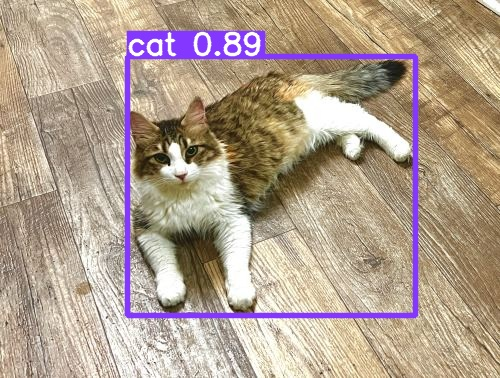

In [41]:
# change this section accordin to your data requirement
my_box = np.array([])
for i, item in enumerate(results[0].cpu().numpy()):
  if item.boxes.cls == 15:  # pick the first box for detected object, class 15 (i.e. cat)
    my_box = item.boxes.xyxy
    break
my_box[0].astype('int').tolist()

[127, 56, 415, 315]

# SAM -- Prompt Segmentation

In [42]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [43]:
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda" 

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [44]:
predictor.set_image(image)

This is where we use the object detection box as the input prompt for SAM.

In [45]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=my_box[None, :],
    multimask_output=False,
)

In [46]:
# helper functions 

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image) 
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

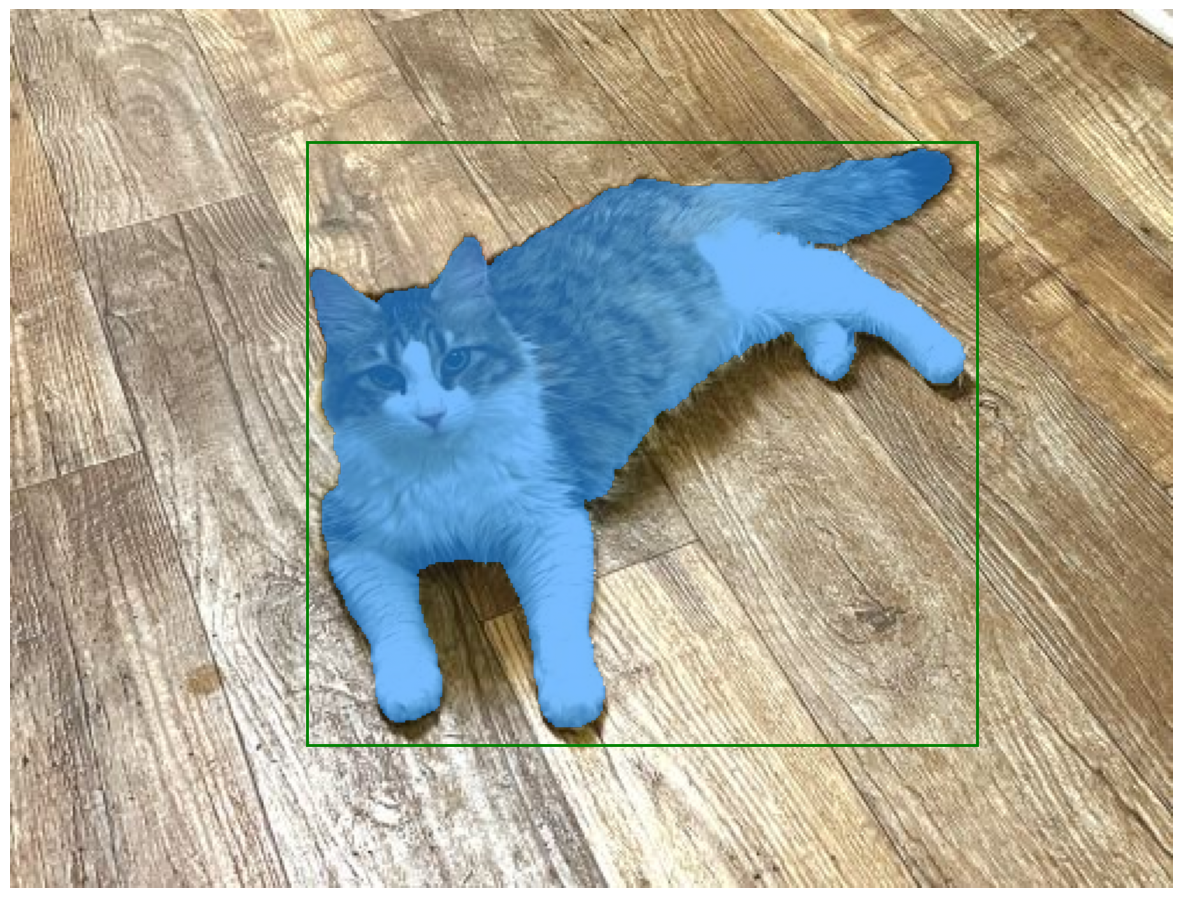

In [47]:
plt.figure(figsize=(15, 15))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(my_box[0], plt.gca())
plt.axis('off')
plt.show()